In [ ]:
# GDAL commands used to select the portions of data sources that we need

# Select shapefiles from the OSM data
!ogr2ogr -sql "SELECT * FROM multipolygons WHERE admin_level='8'" -f "ESRI Shapefile" bay_area_cities bay_area.osm.pbf
# Select populations from the OSM data
!ogr2ogr -sql "SELECT * FROM points WHERE population IS NOT NULL and name IS NOT NULL" -f "GeoJSON" bay_area_cities.geojson bay_area.osm.pbf 
# Merge a set of downloaded SRTM elevation data
!gdal_merge.py -o bay_area.tif -of GTiff bay_area_data/N3?W12?.hgt

In [1]:
import json
import itertools

import numpy as np
import numpy.ma as ma

import gdal

import matplotlib.pyplot as plt
from matplotlib.image import imread
from matplotlib.colors import LightSource, LinearSegmentedColormap

import cartopy.crs as ccrs
from cartopy.io import shapereader

from graph_coloring import generate_intersections, greedy_coloring

In [2]:
# Read the city shapefiles and generate the neighbors map
reader = shapereader.Reader('bay_area_cities/multipolygons.shp')

# Atherton is missing from OSM: get it from an alternative source
sm_reader = shapereader.Reader('san_mateo/City_Boundaries.shp')
atherton = next(item for item in sm_reader.records() if 'ATHERTON' in item.attributes['NAME'])
atherton.attributes['name'] = 'Atherton'

records = list(reader.records())
records.insert(0, atherton)

In [3]:
intersections = generate_intersections(records, verbose=False)

In [4]:
# From the neighbors map, assign colors to the cities
colors =['#e41a1c', '#4daf4a', '#984ea3', '#ff7f00', '#ffff33']
colormap = greedy_coloring(intersections, colors)

In [5]:
# Open the SRTM elevation file and compute a hillslope
# shaded relief dataset.
data = gdal.Open('bay_area.tif')
arr = data.ReadAsArray()
ls = LightSource()
intensity = ls.hillshade(arr, vert_exag=0.5)

# Construct a mask for water
water = ma.masked_where(arr != 0, np.ones_like(arr))

In [6]:
# Load the population dataset, and construct
# a dictionary containing the population of
# each city.
f = open('bay_area_cities.geojson')
city_data = json.load(f)
replace = { 'San José': b'San Jos\xe9' }
population = dict()
for record in city_data['features']:
    name = record['properties']['name']
    name = replace[name] if name in replace else name
    # Some populations contain commas, so strip those
    pop = int(record['properties']['population'].replace(',',''))
    if name in population:
        continue
    population[name] = pop

In [7]:
# The label for cities is plotted at the centroid of the shape,
# which is not always the best choice.
# This is a dictionary of manually chosen lon/lat shifts for the
# labels to make the map look good.
tweaks = {
    "San Francisco": [0.25, 0.0],
    "Oakland": [-0.05, 0.04],
    "Richmond": [0.00, -0.02],
    "Fremont": [0.05, 0.0],
    "Hercules": [0.02, -0.02],
    "Pinole": [0.02, -0.015],
    "Brisbane": [-0.05, 0.0],
    "South San Francisco": [-0.05, 0.0],
    "San Mateo": [0.0, 0.01],
    "Foster City": [-0.01, -0.02],
    "Fairfield": [0.0, 0.03],
    "Los Altos" : [0.0, 0.01],
    "Albany": [0.01, 0.0],
    "Palo Alto": [0.0, 0.02]
}

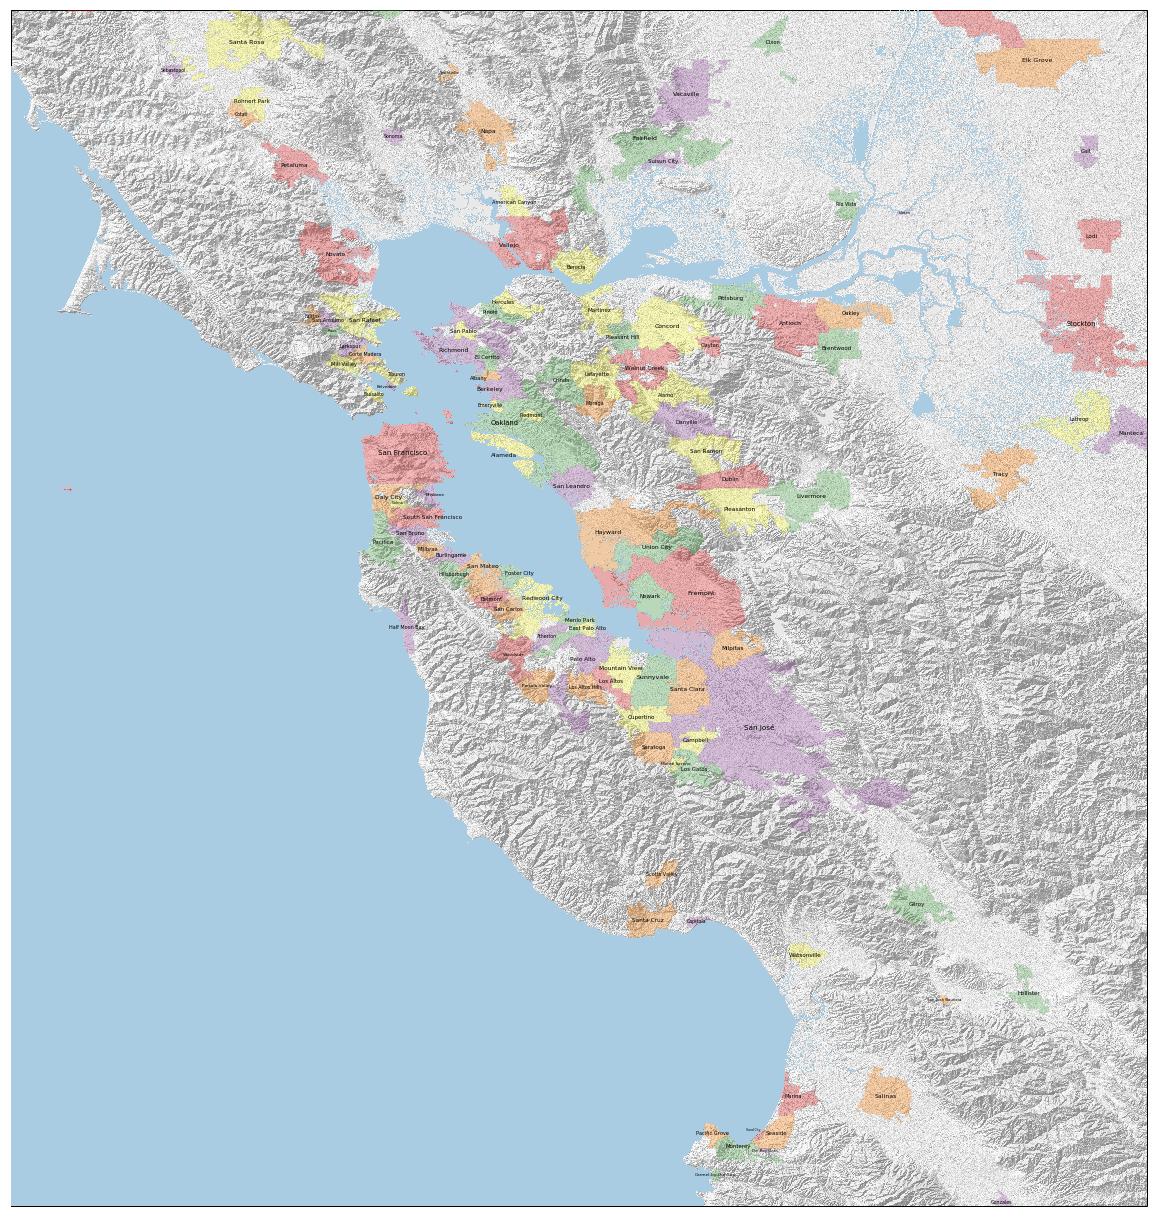

In [10]:
# Construct the map!

fig = plt.figure(figsize=(22, 22))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-123.1,-121.2, 36.5, 38.5]) # Full SF metro area

srtm_extent=[-124.0001389, -120.9998611, 35.9998611, 39.0001389]
ax.imshow(intensity, cmap='gist_gray', alpha=0.5, origin='upper', extent=srtm_extent, zorder=0)

# Duplicated cities or non-cities that we should skip.
skip = ['City of Cupertino Service Center', 'Bodega Bay', 'Stanford', 'Foothills Park', 'Unity']
replace = { b'San Jos\xe9': 'San José' }
cities = set()
for record in records:
    name = record.attributes['name']
    geometry = record.geometry
    if name == '' or name in cities or name in skip:
        continue
    cities.add(name)
    ax.add_geometries([geometry], ccrs.PlateCarree(), 
                      alpha=0.3, color=colormap[name], 
                      edgecolor='k', lw=0.1, zorder=5)
    # If the population is in the population map (as it is for most cities),
    # assign the font size to the log of the population
    if population.get(name):
        size = np.log10(population[name])*1.2 if population[name] > 0 else 1
    else: 
        size = np.log10(10000)
    label = name if name not in replace else replace[name]
    # Compute the x and y position of the labels, considering the tweaks dictionary
    x = geometry.centroid.x
    y = geometry.centroid.y
    if tweaks.get(name):
        x += tweaks[name][0]
        y += tweaks[name][1]
    ax.text(x, y, label, fontsize=size, zorder=20, clip_on=True,
            ha='center', va='center', transform=ccrs.PlateCarree())

#Make a pure blue colormap, and plot the water mask
cm = LinearSegmentedColormap.from_list('water', [(169/255, 204/255, 227/255),(169/255, 204/255, 227/255)])
ax.imshow(water, cmap=cm, origin='upper', alpha=1.0, extent=srtm_extent, zorder=10)

# Save at a high resolution
plt.savefig('bay_area_cities.png', bbox_inches='tight', dpi=600)
plt.show()